## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
import torch.nn.functional as F


import datetime

top-5 models

- score 0.68: https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-512-v1#model

"/kaggle/input/25d-segmentaion-baseline-training-models/image-512-weighted-loss-v2/image-512-weighted-loss-v2/resnet34_3d_seg_best_0.960.pt"


- score 0.66: https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-768?scriptVersionId=131305396

"/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/resnet18_3d_seg_best_0.5364.pt"


- score 0.65 : https://www.kaggle.com/code/viktorcikojevic/fork-of-2-5d-segmentaion-baseline-256#model

"/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss/exp-1-reproduce-training-with-augm-bce-dice-loss/resnet18_3d_seg_best_0.5526.pt"

- score 0.58: https://www.kaggle.com/code/viktorcikojevic/focal-loss-ensemble-1#model (V2)

"/kaggle/input/25d-segmentaion-baseline-training-models/focal-loss-folds/focal-loss-folds/resnet18_3d_seg_best_0.5512-fold-1.pt"

- score 0.51: https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-1024#model

https://www.kaggle.com/code/viktorcikojevic/2-5d-segmentaion-baseline-1024#model

"/kaggle/input/25d-segmentaion-baseline-training-models/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768-cont-1024/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768-cont-1024/resnet18_3d_seg_best_0.5594.pt"





In [2]:
import zarr

FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

## model

## main

In [5]:
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

In [6]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR["1"].truth)).float().cuda()
gt_mask.shape

torch.Size([8181, 6330])

In [7]:
fragment = FRAGMENTS_ZARR["1"]
fragment = fragment.surface_volume
fragment.shape#, fragment.min(), fragment.max()

(8181, 6330, 65)

In [8]:
binary_mask = FRAGMENTS_ZARR["1"].mask
binary_mask.shape

(8181, 6330)

In [19]:
import numpy as np

take_indices = [3, 4, 5, 6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

take_indices = [3, 4, 5, 6, 19, 20, 21, 22, 23, 24]

final_pred = np.zeros_like(binary_mask, dtype=np.float32)

for indx in take_indices:
    arr = np.load(f"mask_pred_{indx}.npy")
    final_pred += arr
    
final_pred = final_pred / len(take_indices)
    

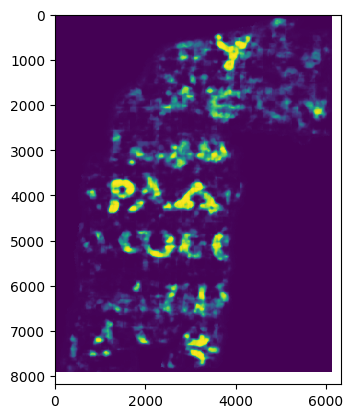

In [20]:
plt.imshow(final_pred)

In [21]:
final_mask_pred_raw_cuda = torch.tensor(final_pred).cuda()

In [22]:
fbeta_best = 0
best_threshold = 0
th_all_s = []
fbeta_all_s = []
for th in np.arange(0.05, 1.00, 0.01):
    fbeta = fbeta_score(final_mask_pred_raw_cuda, gt_mask, th).item()
    print(th, fbeta)
    th_all_s.append(th)
    fbeta_all_s.append(fbeta)
    if fbeta > fbeta_best:
        fbeta_best = fbeta
        best_threshold = th
print(fbeta_best, best_threshold)

0.05 0.44093433022499084
0.060000000000000005 0.4602266848087311
0.07 0.4773385524749756
0.08000000000000002 0.4928014874458313
0.09000000000000001 0.5068418383598328
0.1 0.5199116468429565
0.11000000000000001 0.5314826369285583
0.12000000000000001 0.5433375239372253
0.13 0.5541681051254272
0.14 0.5636751055717468
0.15000000000000002 0.5726448893547058
0.16000000000000003 0.5814738869667053
0.17000000000000004 0.5893092751502991
0.18000000000000005 0.5967691540718079
0.19 0.6032917499542236
0.2 0.6094259023666382
0.21000000000000002 0.6155370473861694
0.22000000000000003 0.6210898160934448
0.23000000000000004 0.6260494589805603
0.24000000000000005 0.6311467289924622
0.25000000000000006 0.6360529661178589
0.26000000000000006 0.6400859951972961
0.27 0.6439757943153381
0.28 0.6480759978294373
0.29000000000000004 0.6520517468452454
0.30000000000000004 0.6559471487998962
0.31000000000000005 0.6595385074615479
0.32000000000000006 0.6630539298057556
0.33 0.6663053631782532
0.34 0.669129133224

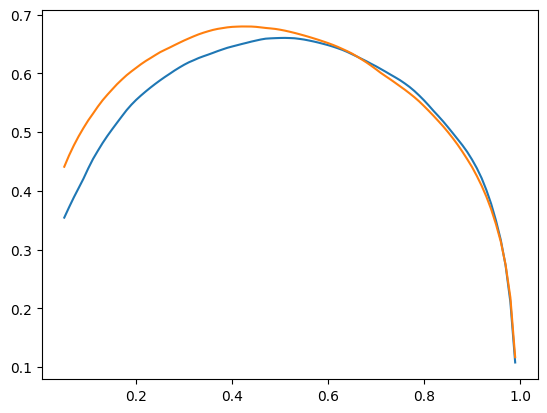

In [23]:
plt.plot(th_all, fbeta_all)
plt.plot(th_all_s, fbeta_all_s)

# Summary:

Best model performance: 0.6343


## All models


- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.62571 0.5400
- Majority vote:
    - print(fbeta_best, best_threshold) -> 0.603 0.4000


## Only models 2, 3, 4:

- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.63267 0.530
- Majority vote:
    - print(fbeta_best, best_threshold) -> 0.62415 0.34


## Only models 3, 4 (two best models):

- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.63195 0.580




## Only models 1, 2 (one trained with BCE, one with Focal loss)

Both have 0.56 Fbeta score.

- Average of all probs:
    - print(fbeta_best, best_threshold) -> 0.5675 0.0.48

In [398]:
# stride 2: 
# stride 5: 0.5288561582565308 0.6700000000000002


